(400, 600, 3)


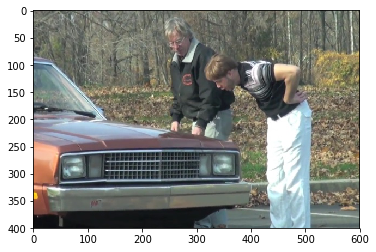

In [36]:
import sys
sys.path.insert(0, "./")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Let's start by importing the image as numpy array

% matplotlib inline

data_dir = "./data/"
img = mpimg.imread(data_dir + "look_at_it.jpg")
imgplot = plt.imshow(img)
print(img.shape)

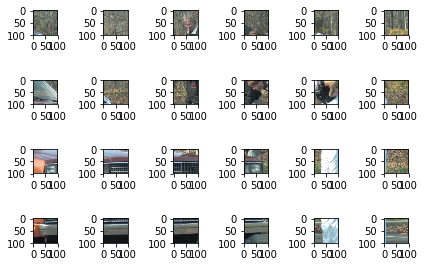

In [49]:
## Let's split the image into chunks
def split_2d_image(img):
    row_imgs = np.vsplit(img, 4)
    img_list = []
    for row in row_imgs:
        img_list.append(np.hsplit(row, 6))
    return img_list

img_list = split_2d_image(img)
fig=plt.figure(figsize=(len(img_list[0]), len(img_list)))
rows = len(img_list)
columns = len(img_list[0])
count = 1

for row in range(rows):
    for col in range(columns):
        fig.add_subplot(rows, columns, count)
        plt.imshow(img_list[row][col],interpolation='nearest')
        count += 1

fig.tight_layout()
plt.show()

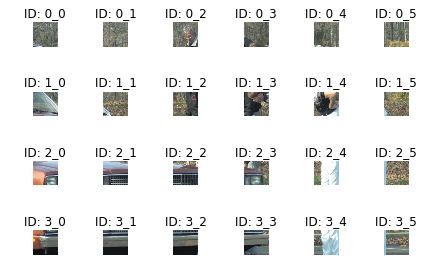

In [51]:
## Now we need to attach relevant ID's to each image. 
## This is so when we map the image pieces back together, they will know where to go.
## There are multiple ways of doing this... TODO: think of best way

## Most obvious: Two digit ID's: XY where first digit corresponds to row and second digit corresponds to column

image_map = {}

for row in range(rows):
    for col in range(columns):
        image_map[str(row) + '_' + str(col)] = img_list[row][col]

fig=plt.figure(figsize=(len(img_list[0]), len(img_list)))
count = 1
for key, value in image_map.items():
    fig.add_subplot(rows, columns, count).title.set_text("ID: " + key)
    plt.imshow(value,interpolation='nearest')
    plt.axis('off')
    count += 1

fig.tight_layout()
plt.show()

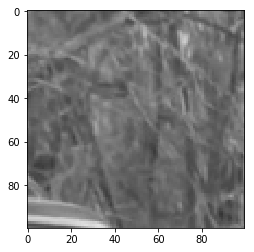

In [52]:
## Now we set a function that will be applied over each image chunk.
## We will use a very simple function for now: make everyting grayscale and wait 5 seconds (to make parallel time more apparent)!
import time

def crappy_function(sec, img):
    img.setflags(write=1)
    for y in range(len(img)):
        for x in range(len(img[0])):
            img[y][x] = [np.sum(img[y][x])/3]*3
            time.sleep(sec)
    return img

## Test crappy function to make sure it works
test = crappy_function(.001, next (iter (image_map.values())) )
plt.imshow(test)



In [24]:
## Parallel Time
## We will use Python Multiprocessing for now and switch to Scala or a Framework
## Each thread available will take on an image and do crappy function
## The thread will return the result to a list with correct size.

import threading

## result dictionary

result_list = [[None for i in range(columns)] for j in range(rows)]

## Threading lock for good practice
lock = threading.Lock()

def worker(sec, key, img):
    result = crappy_function(sec, img)
    print("Waiting for lock...\n")
    lock.acquire()
    print("Lock acquired\n")
    try:
        row, col = (key.split("_"))
        result_list[int(row)][int(col)] = result
    finally:
        print("Lock released\n")
        lock.release()

for key, value in image_map.items():
    t = threading.Thread(target = worker, args = (.001, key, value))
    t.start()

Waiting for lock...

Lock acquired

Lock released

Waiting for lock...

Lock acquired

Lock released

Waiting for lock...

Lock acquired

Lock released

Waiting for lock...

Waiting for lock...
Lock acquired


Lock acquired
Lock released


Lock released

Waiting for lock...

Waiting for lock...
Waiting for lock...
Waiting for lock...
Lock acquired




Lock acquired
Lock acquired
Waiting for lock...
Lock released



Lock acquired
Waiting for lock...
Waiting for lock...

Lock released
Lock released
Lock acquired



Waiting for lock...
Waiting for lock...
Waiting for lock...
Waiting for lock...




Lock released
Lock acquired
Lock acquired



Lock acquired
Lock acquired
Lock acquired
Lock released



Lock acquired




Waiting for lock...
Lock released
Lock released

Lock released
Lock released
Lock released
Waiting for lock...



Lock released
Waiting for lock...
Waiting for lock...




Lock acquired



Lock acquired
Lock acquired

Lock acquired


Lock released

Lock released
Lock release

In [25]:
# Brief Sanity Check
print(len(result_list))

4


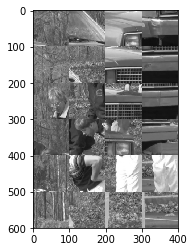

In [53]:
## Now time to merge results back into image
## This is a crappy way of doing it.. we will eventually find a better way

def merge(result_list):
    merged_rows = []
    for row in result_list:
        merged_row = row[0]
        for col in row[1:]:
            merged_row = np.concatenate((merged_row, col), axis = 0)
        merged_rows.append(merged_row)
    
    img = merged_rows[0]
    for row in merged_rows[1:]:
        img = np.concatenate((img, row), axis = 1)
    return img

new_image = merge(result_list)
imgplot = plt.imshow(new_image)

# Improvements / TODOs:
- There is probably a better way to merge 
- There is definitely a better parallel programming framework
- Edge Conflicts (!!!)

Look into: Memory Mapping